In [42]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt          
import seaborn as sns  

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [43]:
df = pd.read_pickle("../ensemble/combined.pkl")
df.head()

,time_millisecond,latitude,longitude,height_above_takeoff_feet,height_above_ground_at_drone_location_feet,ground_elevation_at_drone_location_feet,altitude_above_sealevel_feet,height_sonar_feet,speed_mph,distance_feet,...,rc_rudder_percent,gimbal_heading_degrees,gimbal_pitch_degrees,gimbal_roll_degrees,battery_percent,current_a,battery_temperature_f,altitude_feet,ascent_feet,flycstateraw
0,5510,36.559037,-89.074368,29.855644,29.855644,367.743461,397.599105,0,0.000000,0.000000,...,0,254.4,-90.0,0,93,15.88,29.950016,397.599105,29.855644,14
1,5610,36.559037,-89.074368,30.839896,30.839896,367.743461,398.583357,0,0.000000,0.047036,...,0,254.4,-90.0,0,93,15.88,29.950016,398.583357,30.839896,14
2,5710,36.559037,-89.074368,31.824148,31.824148,367.743461,399.567609,0,0.000000,0.095541,...,0,254.4,-90.0,0,93,15.88,29.950016,399.567609,31.824148,14
3,5810,36.559037,-89.074367,32.808400,32.808400,367.743461,400.551861,0,0.000000,0.139809,...,0,254.4,-90.0,0,93,15.88,29.950016,400.551861,32.808400,14
4,5910,36.559037,-89.074367,33.792652,33.792652,367.743461,401.536113,0,0.223694,0.174553,...,0,254.4,-89.9,0,93,15.88,29.950016,401.536113,33.792652,14


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8127 entries, 0 to 8126
Data columns (total 42 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   time_millisecond                            8127 non-null   int64  
 1   latitude                                    8127 non-null   float64
 2   longitude                                   8127 non-null   float64
 3   height_above_takeoff_feet                   8127 non-null   float64
 4   height_above_ground_at_drone_location_feet  8127 non-null   float64
 5   ground_elevation_at_drone_location_feet     8127 non-null   float64
 6   altitude_above_sealevel_feet                8127 non-null   float64
 7   height_sonar_feet                           8127 non-null   int64  
 8   speed_mph                                   8127 non-null   float64
 9   distance_feet                               8127 non-null   float64
 10  mileage_feet

In [45]:
# datainfo = df.info()
# type(datainfo)

# for name, do in datainfo.items():
#     print(name)

In [46]:
X = df.drop(columns=["battery_temperature_f"])
y = df["battery_temperature_f"]

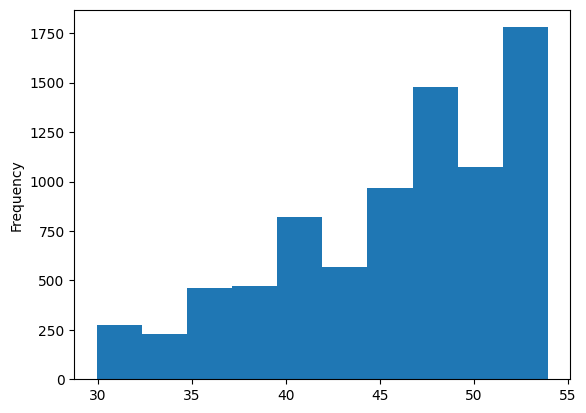

In [47]:
df["battery_temperature_f"].plot(kind="hist", bins=10)
plt.show()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stack the Models -- 🪜❌

In [49]:
# Define model structure 
# lasso -> RandomForest -> XGBOOST
# predictor - Ridge Regression

In [50]:
lasso = Pipeline([("scaler", StandardScaler()),
                  ("lasso", Lasso(alpha=0.01, random_state=42))])

rf = RandomForestRegressor(random_state=42, 
                            n_estimators=300,
                            max_depth=None)

xgb = XGBRegressor(n_estimators=300,
                   learning_rate=0.05,
                   max_depth=6,
                   random_state=42,
                   colsample_bytree=0.8,
                   subsample=0.8)

In [51]:
mymodels = {"lasso":lasso,
            "rf":rf,
            "xgb":xgb
            }

In [52]:
for modelname, model in mymodels.items():
    model.fit(X_train, y_train)
    y_predict = model.predict(X_train)
    
    print(f"{modelname} mae: {mean_absolute_error(y_predict, y_train):.3f}")
    print(f"{modelname} r-squared: {r2_score(y_predict, y_train):.3f}")

lasso mae: 0.341
lasso r-squared: 0.995
rf mae: 0.002
rf r-squared: 1.000
xgb mae: 0.002
xgb r-squared: 1.000


In [53]:
estimators = [("lasso",lasso),
              ("rf", rf),
              ("xgb", xgb)]

print(estimators)

[('lasso', Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01, random_state=42))])), ('rf', RandomForestRegressor(n_estimators=300, random_state=42)), ('xgb', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...))]


In [54]:
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1),
    cv=10,
    n_jobs=-1
)

In [55]:
stack.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.","[('lasso', ...), ('rf', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA regressor which will be used to combine the base estimators.The default regressor is a :class:`~sklearn.linear_model.RidgeCV`.",Ridge(alpha=1)
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",10
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",-1
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",0.01
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True


In [56]:
y_predict = stack.predict(X_test)

print(f"mae: {mean_absolute_error(y_predict, y_test):.3f}")
print(f"r-squared: {r2_score(y_predict, y_test):.3f}")

mae: 0.006
r-squared: 1.000


In [57]:
mae = mean_absolute_error(y_test, y_predict)
r2_score = r2_score(y_test, y_predict)

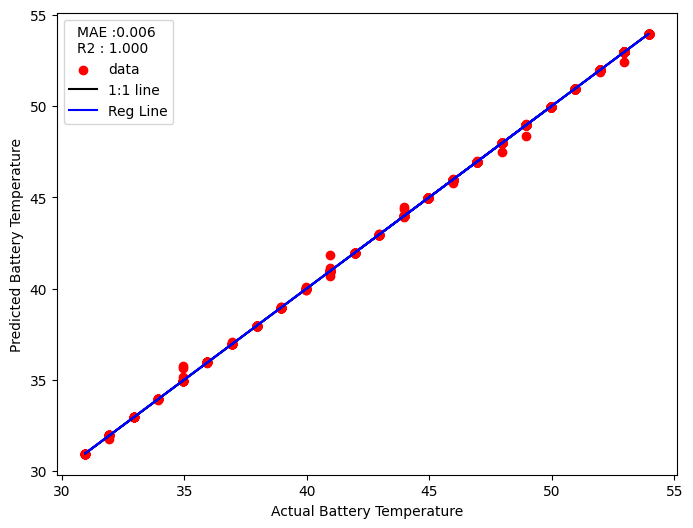

In [58]:
# Plot of y_test and y_predict 
slope, constant = np.polyfit(y_test, y_predict, 1)

plt.figure(figsize=(8,6))
plt.scatter(x=y_test, y=y_predict, label="data", color="red")
plt.plot(y_test, y_test, label="1:1 line", color="black")
plt.plot(y_test, slope*y_test + constant, color="blue", label="Reg Line")

plt.ylabel("Predicted Battery Temperature")
plt.xlabel("Actual Battery Temperature")

plt.legend(title=f"MAE :{mae:.3f} \nR2 : {r2_score:.3f}")
plt.show()

# shap values❌❌

In [61]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)


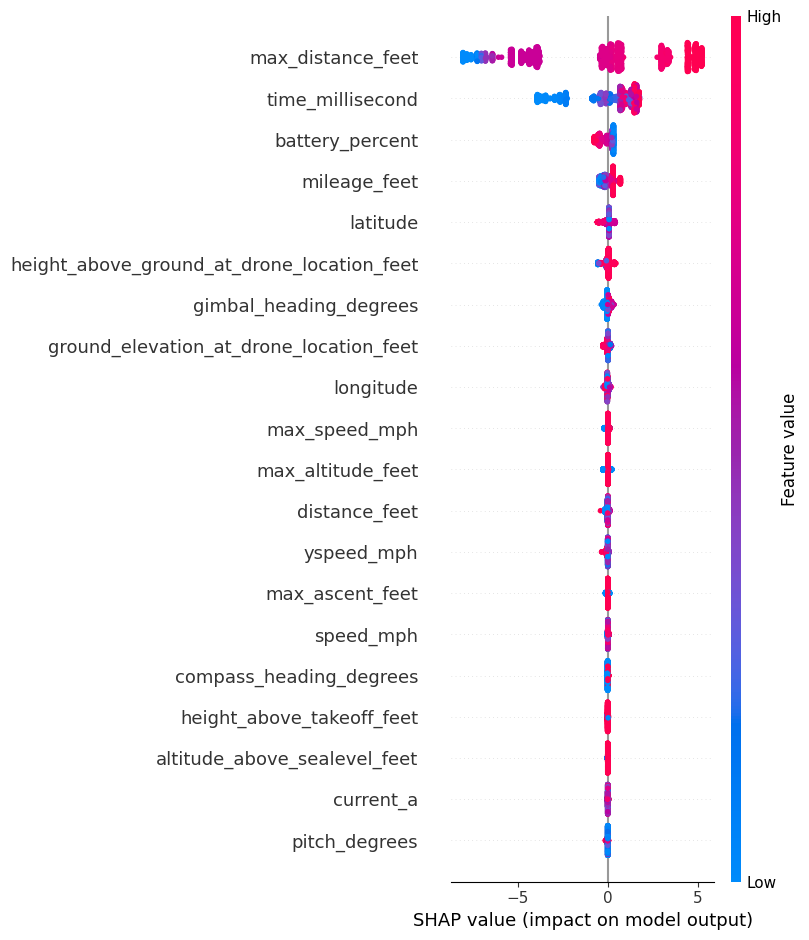

In [62]:
shap.summary_plot(
    shap_values,
    X_test,
    plot_type="dot"
)